<a href="https://colab.research.google.com/github/OrderAndCh4oS/phonetic-translation-ml-seq2seq-attention/blob/main/eng_to_ipa_seq2seq_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import numpy as np
import pandas as pd

import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pathlib

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
np.set_printoptions(precision=3, suppress=True)

In [15]:
class ShapeChecker:
    def __init__(self):
        # Keep a cache of every axis-name seen
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        if isinstance(names, str):
            names = (names,)

        shape = tf.shape(tensor)
        rank = tf.rank(tensor)

        if rank != len(names):
            raise ValueError(
                f'Rank mismatch:\n'
                f'    found {rank}: {shape.numpy()}\n'
                f'    expected {len(names)}: {names}\n'
            )

        for i, name in enumerate(names):
            if isinstance(name, int):
                old_dim = name
            else:
                old_dim = self.shapes.get(name, None)
            new_dim = shape[i]

            if broadcast and new_dim == 1:
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(
                    f"Shape mismatch for dimension: '{name}'\n"
                    f"    found: {new_dim}\n"
                    f"    expected: {old_dim}\n"
                )

In [16]:
import re

regex = r"(,.*)"

def load_data(path):
    data = pd.read_csv(path, delimiter='\t').replace(np.nan, '')

    pairs = np.array(data)
    for x in pairs:
        if not isinstance(x[0], str):
            print(x[0])

    inp = [' '.join(x[0]) for x in pairs]
    targ = [' '.join(x[1]) for x in pairs]

    return targ, inp


# targ, inp = load_data('ipa_pairs_all.csv')
targ, inp = load_data('en_UK.csv')
print(inp[-1])
print(targ[-1])

ü b e r m e n s c h
/ ʔ y ː b ɐ m ɛ n ʃ /


In [17]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

In [18]:
dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5])
    print()
    print(example_target_batch[:5])
    break

example_text = tf.constant('l u ː t')

print(example_text.numpy())

tf.Tensor(
[b'r e c e d i n g' b's i m p l i f i e s' b'c l a r i f y i n g'
 b's e r v i c e m a n' b'f a r m e r s'], shape=(5,), dtype=string)

tf.Tensor(
[b'/ \xc9\xb9 \xc9\xaa s \xcb\x88 i \xcb\x90 d \xc9\xaa \xc5\x8b /'
 b'/ s \xcb\x88 \xc9\xaa m p l \xc9\xaa f \xcb\x8c a \xc9\xaa z /'
 b'/ k l \xcb\x88 \xc3\xa6 \xc9\xb9 \xc9\xaa f \xcb\x8c a \xc9\xaa \xc9\xaa \xc5\x8b /'
 b'/ s \xcb\x88 \xc9\x9c \xcb\x90 v \xc9\xaa s m \xc9\x99 n /'
 b'/ f \xcb\x88 \xc9\x91 \xcb\x90 m \xc9\x99 z /'], shape=(5,), dtype=string)
b'l u \xcb\x90 t'


In [19]:
def tf_lower_and_split_punct(text):
    # Split accented characters.
    # Keep space, a to z, and select punctuation.
    # Add spaces around punctuation.
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text


print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

l u ː t
[START] l u ː t [END]


In [20]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size
)

input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
print(input_text_processor.get_vocabulary()[:10])

['', '[UNK]', '[START]', '[END]', 'e', 's', 'i', 'a', 'r', 'n']


In [21]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size
)

output_text_processor.adapt(targ)
print(output_text_processor.get_vocabulary()[:10])

['', '[UNK]', '/', '[START]', '[END]', 'ˈ', 'ɪ', 'ə', 't', 's']


In [22]:
example_tokens = input_text_processor(example_input_batch)
print(example_tokens[:3, :10])

tf.Tensor(
[[ 2  8  4 13  4 14  6  9 16  3]
 [ 2  5  6 18 17 12  6 22  6  4]
 [ 2 13 12  7  8  6 22 21  6  9]], shape=(3, 10), dtype=int64)


In [23]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
print(''.join(tokens))

[START]receding[END]


Text(0.5, 1.0, 'Mask')

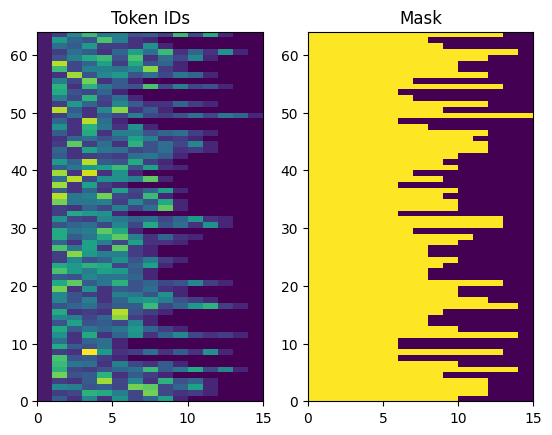

In [24]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [25]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(
            self.input_vocab_size,
            embedding_dim
        )

        # The GRU RNN layer processes those vectors sequentially.
        self.gru = tf.keras.layers.GRU(
            self.enc_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform'
        )

    def call(self, tokens, state=None):
        shape_checker = ShapeChecker()
        shape_checker(tokens, ('batch', 's'))

        # 2. The embedding layer looks up the embedding for each token.
        vectors = self.embedding(tokens)
        shape_checker(vectors, ('batch', 's', 'embed_dim'))

        # 3. The GRU processes the embedding sequence.
        #    output shape: (batch, s, enc_units)
        #    state shape: (batch, enc_units)
        output, state = self.gru(vectors, initial_state=state)
        shape_checker(output, ('batch', 's', 'enc_units'))
        shape_checker(state, ('batch', 'enc_units'))

        # 4. Returns the new sequence and its state.
        return output, state

In [26]:
embedding_dim = 256
units = 1024

In [27]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(), embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 15)
Encoder output, shape (batch, s, units): (64, 15, 1024)
Encoder state, shape (batch, units): (64, 1024)


In [28]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        # For Eqn. (4), the  Bahdanau attention
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
        shape_checker = ShapeChecker()
        shape_checker(query, ('batch', 't', 'query_units'))
        shape_checker(value, ('batch', 's', 'value_units'))
        shape_checker(mask, ('batch', 's'))

        # From Eqn. (4), `W1@ht`.
        w1_query = self.W1(query)
        shape_checker(w1_query, ('batch', 't', 'attn_units'))

        # From Eqn. (4), `W2@hs`.
        w2_key = self.W2(value)
        shape_checker(w2_key, ('batch', 's', 'attn_units'))

        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        context_vector, attention_weights = self.attention(
            inputs=[w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores=True,
        )
        shape_checker(context_vector, ('batch', 't', 'value_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))

        return context_vector, attention_weights

In [29]:
attention_layer = BahdanauAttention(units)
print((example_tokens != 0).shape)

(64, 15)


In [30]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens
context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0)
)

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 15)


Text(0.5, 1.0, 'Mask')

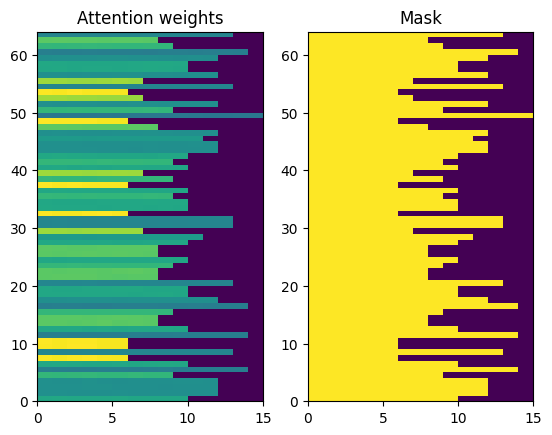

In [31]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [32]:
print(attention_weights.shape)

(64, 2, 15)


In [33]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 640x480 with 0 Axes>

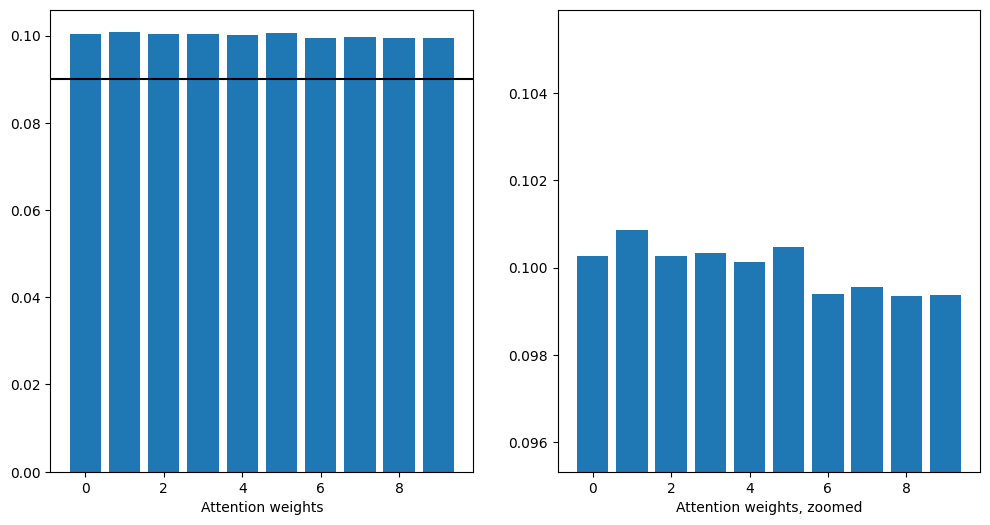

In [34]:
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85 * top
a2.set_ylim([0.90 * top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

In [35]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        # For Step 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(
            self.output_vocab_size,
            embedding_dim
        )

        # For Step 2. The RNN keeps track of what's been generated so far.
        self.gru = tf.keras.layers.GRU(
            self.dec_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform'
        )

        # For step 3. The RNN output will be the query for the attention layer.
        self.attention = BahdanauAttention(self.dec_units)

        # For step 4. Eqn. (3): converting `ct` to `at`
        self.Wc = tf.keras.layers.Dense(
            dec_units,
            activation=tf.math.tanh,
            use_bias=False
        )

        # For step 5. This fully connected layer produces the logits for each
        # output token.
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [36]:
class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any


class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

In [37]:
def call(
        self,
        inputs: DecoderInput,
        state=None
) -> Tuple[DecoderOutput, tf.Tensor]:
    shape_checker = ShapeChecker()
    shape_checker(inputs.new_tokens, ('batch', 't'))
    shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
    shape_checker(inputs.mask, ('batch', 's'))

    if state is not None:
        shape_checker(state, ('batch', 'dec_units'))

    # Step 1. Lookup the embeddings
    vectors = self.embedding(inputs.new_tokens)
    shape_checker(vectors, ('batch', 't', 'embedding_dim'))

    # Step 2. Process one step with the RNN
    rnn_output, state = self.gru(vectors, initial_state=state)

    shape_checker(rnn_output, ('batch', 't', 'dec_units'))
    shape_checker(state, ('batch', 'dec_units'))

    # Step 3. Use the RNN output as the query for the attention over the
    # encoder output.
    context_vector, attention_weights = self.attention(
        query=rnn_output,
        value=inputs.enc_output,
        mask=inputs.mask
    )
    shape_checker(context_vector, ('batch', 't', 'dec_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    # Step 4. Eqn. (3): Join the context_vector and rnn_output
    #     [ct; ht] shape: (batch t, value_units + query_units)
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

    # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
    attention_vector = self.Wc(context_and_rnn_output)
    shape_checker(attention_vector, ('batch', 't', 'dec_units'))

    # Step 5. Generate logit predictions:
    logits = self.fc(attention_vector)
    shape_checker(logits, ('batch', 't', 'output_vocab_size'))

    return DecoderOutput(logits, attention_weights), state

In [38]:
Decoder.call = call

In [39]:
decoder = Decoder(
    output_text_processor.vocabulary_size(),
    embedding_dim,
    units
)

# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

# Run the decoder
dec_result, dec_state = decoder(
    inputs=DecoderInput(
        new_tokens=first_token,
        enc_output=example_enc_output,
        mask=(example_tokens != 0)
    ),
    state=example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 99)
state shape: (batch_size, dec_units) (64, 1024)


In [40]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
print(first_word[:5])

[['̚']
 ['t']
 ['ŋ']
 ['a']
 ['̆']]


In [41]:
dec_result, dec_state = decoder(
    DecoderInput(
        sampled_token,
        example_enc_output,
        mask=(example_tokens != 0)
    ),
    state=dec_state
)

In [42]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
print(first_word[:5])

[['ɪ']
 ['ʷ']
 ['m']
 ['ˀ']
 ['ɛ']]


In [43]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

    def __call__(self, y_true, y_pred):
        shape_checker = ShapeChecker()
        shape_checker(y_true, ('batch', 't'))
        shape_checker(y_pred, ('batch', 't', 'logits'))

        # Calculate the loss for each item in the batch.
        loss = self.loss(y_true, y_pred)
        shape_checker(loss, ('batch', 't'))

        # Mask off the losses on padding.
        mask = tf.cast(y_true != 0, tf.float32)
        shape_checker(mask, ('batch', 't'))
        loss *= mask

        # Return the total.
        return tf.reduce_sum(loss)

In [44]:
class TrainTranslator(tf.keras.Model):
    def __init__(
            self,
            embedding_dim,
            units,
            input_text_processor,
            output_text_processor,
            use_tf_function=True
    ):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(
            input_text_processor.vocabulary_size(),
            embedding_dim,
            units
        )
        decoder = Decoder(
            output_text_processor.vocabulary_size(),
            embedding_dim,
            units
        )

        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function
        self.shape_checker = ShapeChecker()

    def train_step(self, inputs):
        self.shape_checker = ShapeChecker()
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)

In [45]:
def _preprocess(self, input_text, target_text):
    self.shape_checker(input_text, ('batch',))
    self.shape_checker(target_text, ('batch',))

    # Convert the text to token IDs
    input_tokens = self.input_text_processor(input_text)
    target_tokens = self.output_text_processor(target_text)
    self.shape_checker(input_tokens, ('batch', 's'))
    self.shape_checker(target_tokens, ('batch', 't'))

    # Convert IDs to masks.
    input_mask = input_tokens != 0
    self.shape_checker(input_mask, ('batch', 's'))

    target_mask = target_tokens != 0
    self.shape_checker(target_mask, ('batch', 't'))

    return input_tokens, input_mask, target_tokens, target_mask

In [46]:
TrainTranslator._preprocess = _preprocess

In [47]:
def _train_step(self, inputs):
    input_text, target_text = inputs

    (
        input_tokens,
        input_mask,
        target_tokens,
        target_mask
    ) = self._preprocess(input_text, target_text)

    max_target_length = tf.shape(target_tokens)[1]

    with tf.GradientTape() as tape:
        # Encode the input
        enc_output, enc_state = self.encoder(input_tokens)
        self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
        self.shape_checker(enc_state, ('batch', 'enc_units'))

        # Initialize the decoder's state to the encoder's final state.
        # This only works if the encoder and decoder have the same number of
        # units.
        dec_state = enc_state
        loss = tf.constant(0.0)

        for t in tf.range(max_target_length - 1):
            # Pass in two tokens from the target sequence:
            # 1. The current input to the decoder.
            # 2. The target for the decoder's next prediction.
            new_tokens = target_tokens[:, t:t + 2]
            step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                                   enc_output, dec_state)
            loss = loss + step_loss

        # Average the loss over all non padding tokens.
        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

    # Apply an optimization step
    variables = self.trainable_variables
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}


In [48]:
TrainTranslator._train_step = _train_step

In [49]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

    # Run the decoder one step.
    decoder_input = DecoderInput(
        new_tokens=input_token,
        enc_output=enc_output,
        mask=input_mask
    )

    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
    self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
    self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    self.shape_checker(dec_state, ('batch', 'dec_units'))

    # `self.loss` returns the total for non-padded tokens
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)

    return step_loss, dec_state

In [50]:
TrainTranslator._loop_step = _loop_step

In [51]:
translator = TrainTranslator(
    embedding_dim,
    units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False
)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [52]:
np.log(output_text_processor.vocabulary_size())

4.59511985013459

In [53]:
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2409573>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1319914>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9159713>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4024065>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.834148>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.979774>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.184472>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3096178>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.333712>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.291463>}

CPU times: user 1min 31s, sys: 2.29 s, total: 1min 33s
Wall time: 1min 14s


In [54]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
    return self._train_step(inputs)

In [55]:
TrainTranslator._tf_train_step = _tf_train_step

In [56]:
translator.use_tf_function = True

In [57]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.209661>}

In [58]:
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1068137>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.9815407>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.8349876>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.6940465>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.630425>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.640282>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.5321374>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.4578242>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.4177098>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.3865001>}

CPU times: user 1min 12s, sys: 656 ms, total: 1min 13s
Wall time: 45.1 s


....................................................................................................


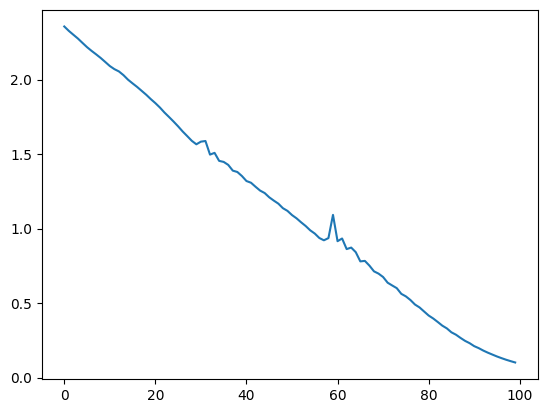

In [59]:
losses = []
for n in range(100):
    print('.', end='')
    logs = translator.train_step([example_input_batch, example_target_batch])
    losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

In [60]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor
)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [61]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []

    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])


batch_loss = BatchLogs('batch_loss')

In [ ]:
train_translator.fit(
    dataset,
    epochs=3,
    callbacks=[batch_loss]
)

Epoch 1/3
  48/1025 [>.............................] - ETA: 1:14:51 - batch_loss: 2.6575

In [ ]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [ ]:
class Translator(tf.Module):

    def __init__(self, encoder, decoder, input_text_processor, output_text_processor):
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor

        self.output_token_string_from_index = (
            tf.keras.layers.StringLookup(
                vocabulary=output_text_processor.get_vocabulary(),
                mask_token='',
                invert=True
            )
        )

        # The output should never generate padding, unknown, or start.
        index_from_string = tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token=''
        )
        token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

        token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask

        self.start_token = index_from_string(tf.constant('[START]'))
        self.end_token = index_from_string(tf.constant('[END]'))


In [ ]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

In [ ]:
def tokens_to_text(self, result_tokens):
    shape_checker = ShapeChecker()
    shape_checker(result_tokens, ('batch', 't'))
    result_text_tokens = self.output_token_string_from_index(result_tokens)
    shape_checker(result_text_tokens, ('batch', 't'))

    result_text = tf.strings.reduce_join(
        result_text_tokens,
        axis=1,
        separator=' '
    )
    shape_checker(result_text, ('batch',))

    result_text = tf.strings.strip(result_text)
    shape_checker(result_text, ('batch',))
    return result_text

In [ ]:
Translator.tokens_to_text = tokens_to_text

In [ ]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2],
    minval=0,
    dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size()
)
translator.tokens_to_text(example_output_tokens).numpy()

In [ ]:
def sample(self, logits, temperature):
    shape_checker = ShapeChecker()
    # 't' is usually 1 here.
    shape_checker(logits, ('batch', 't', 'vocab'))
    shape_checker(self.token_mask, ('vocab',))

    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
    shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

    # Set the logits for all masked tokens to -inf, so they are never chosen.
    logits = tf.where(self.token_mask, -np.inf, logits)

    if temperature == 0.0:
        new_tokens = tf.argmax(logits, axis=-1)
    else:
        logits = tf.squeeze(logits, axis=1)
        new_tokens = tf.random.categorical(logits / temperature,
                                           num_samples=1)

    shape_checker(new_tokens, ('batch', 't'))

    return new_tokens


In [ ]:
Translator.sample = sample

In [ ]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

In [ ]:
def translate_unrolled(
        self,
        input_text,
        *,
        max_length=50,
        return_attention=True,
        temperature=1.0
):
    batch_size = tf.shape(input_text)[0]
    input_tokens = self.input_text_processor(input_text)
    enc_output, enc_state = self.encoder(input_tokens)

    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)

    result_tokens = []
    attention = []
    done = tf.zeros([batch_size, 1], dtype=tf.bool)

    for _ in range(max_length):
        dec_input = DecoderInput(
            new_tokens=new_tokens,
            enc_output=enc_output,
            mask=(input_tokens != 0)
        )

        dec_result, dec_state = self.decoder(dec_input, state=dec_state)

        attention.append(dec_result.attention_weights)

        new_tokens = self.sample(dec_result.logits, temperature)

        # If a sequence produces an `end_token`, set it `done`
        done = done | (new_tokens == self.end_token)
        # Once a sequence is done it only produces 0-padding.
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

        # Collect the generated tokens
        result_tokens.append(new_tokens)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Convert the list of generates token ids to a list of strings.
    result_tokens = tf.concat(result_tokens, axis=-1)
    result_text = self.tokens_to_text(result_tokens)

    if return_attention:
        attention_stack = tf.concat(attention, axis=1)
        return {'text': result_text, 'attention': attention_stack}
    else:
        return {'text': result_text}

In [ ]:
Translator.translate = translate_unrolled

In [ ]:
%%time
input_text = tf.constant([
    'm o t t o',  # mɒtəʊ
    'u n t i d y',  # ʌntaɪdi
    'r a b b i t', # rabbit
    'a b e r c r o m b i e',
    's u m i n s k i'
])

result = translator.translate(input_text=input_text)

print("".join(result['text'][0].numpy().decode().split(' ')))
print("".join(result['text'][1].numpy().decode().split(' ')))
print("".join(result['text'][2].numpy().decode().split(' ')))
print("".join(result['text'][3].numpy().decode().split(' ')))
print("".join(result['text'][4].numpy().decode().split(' ')))
print()

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
    return self.translate(input_text)


Translator.tf_translate = tf_translate

In [ ]:
%%time
result = translator.tf_translate(input_text=input_text)

In [ ]:
%%time
result = translator.tf_translate(input_text=input_text)
print(input_text)

print("".join(result['text'][0].numpy().decode().split(' ')))
print("".join(result['text'][1].numpy().decode().split(' ')))
print("".join(result['text'][2].numpy().decode().split(' ')))
print("".join(result['text'][3].numpy().decode().split(' ')))
print()

In [ ]:
def translate_symbolic(self,
                       input_text,
                       *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  shape_checker = ShapeChecker()
  shape_checker(input_text, ('batch',))

  batch_size = tf.shape(input_text)[0]

  # Encode the input
  input_tokens = self.input_text_processor(input_text)
  shape_checker(input_tokens, ('batch', 's'))

  enc_output, enc_state = self.encoder(input_tokens)
  shape_checker(enc_output, ('batch', 's', 'enc_units'))
  shape_checker(enc_state, ('batch', 'enc_units'))

  # Initialize the decoder
  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)
  shape_checker(new_tokens, ('batch', 't1'))

  # Initialize the accumulators
  result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
  attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  shape_checker(done, ('batch', 't1'))

  for t in tf.range(max_length):
    dec_input = DecoderInput(
        new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens != 0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    attention = attention.write(t, dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)
    shape_checker(dec_result.logits, ('batch', 't1', 'vocab'))
    shape_checker(new_tokens, ('batch', 't1'))

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens = result_tokens.write(t, new_tokens)

    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  result_tokens = result_tokens.stack()
  shape_checker(result_tokens, ('t', 'batch', 't0'))
  result_tokens = tf.squeeze(result_tokens, -1)
  result_tokens = tf.transpose(result_tokens, [1, 0])
  shape_checker(result_tokens, ('batch', 't'))

  result_text = self.tokens_to_text(result_tokens)
  shape_checker(result_text, ('batch',))

  if return_attention:
    attention_stack = attention.stack()
    shape_checker(attention_stack, ('t', 'batch', 't1', 's'))

    attention_stack = tf.squeeze(attention_stack, 2)
    shape_checker(attention_stack, ('t', 'batch', 's'))

    attention_stack = tf.transpose(attention_stack, [1, 0, 2])
    shape_checker(attention_stack, ('batch', 't', 's'))

    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [ ]:
Translator.translate = translate_symbolic


In [ ]:
%%time
result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

In [ ]:
a = result['attention'][0]

print(np.sum(a, axis=-1))

In [ ]:
_ = plt.bar(range(len(a[0, :])), a[0, :])


In [ ]:
plt.imshow(np.array(a), vmin=0.0)


In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

In [ ]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

In [ ]:
%%time
three_input_text = tf.constant([
    # This is my life.
    'e x t r a v a g a n t',
    # Are they still home?
    'o l i v e',
    # Try to find out.'
    'm e n t i o n',
])

result = translator.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

In [ ]:
result['text']


In [ ]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

In [ ]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

In [ ]:
i = 2

plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

In [ ]:
long_str = 'p n e u m o n o u l t r a m i c r o s c o p i c s i l i c o v o l c a n o c o n i o s i s'
long_input_text = tf.constant([long_str])

import textwrap
print('Expected output:\n', ''.join(long_str.split(' ')))

In [ ]:
result = translator.tf_translate(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('This never works')

In [ ]:
# tf.saved_model.save(translator, 'ipa_translator',
#                     signatures={'serving_default': translator.tf_translate})

In [ ]:
# reloaded = tf.saved_model.load('ipa_translator')
# result = reloaded.tf_translate(three_input_text)

In [ ]:
tf.saved_model.save(translator, '/content/drive/MyDrive/eng-to-ipa/ipa_translator',
                    signatures={'serving_default': translator.tf_translate})

In [ ]:
reloaded = tf.saved_model.load('/content/drive/MyDrive/eng-to-ipa/ipa_translator')
result = reloaded.tf_translate(three_input_text)

In [ ]:
%%time
result = reloaded.tf_translate(three_input_text)

for tr in result['text']:
  print(''.join(tr.numpy().decode().split(' ')))

print()